# Part 1. Convert video to images then to array

In [ ]:
# Mount google drive to access files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2

def convert_video_to_images(img_folder, filename='video.avi'):
    """
    Converts the video file (video.avi) to JPEG images.
    Once the video has been converted to images, then this function doesn't need to be run again.
    
    Arguments
    ---------
    filename : (string) file name (absolute or relative path) of video file.
    img_folder : (string) folder where the video frames will be
    stored as JPEG images.
    """
    # Make the img_folder if it doesn't exist.
    try:
        if not os.path.exists(img_folder):
            os.makedirs(img_folder)
    except OSError:
        print('Error')

    # Make sure that the abscense/prescence of path separator doesn't throw an error.
    img_folder = f'{img_folder.rstrip(os.path.sep)}{os.path.sep}'
    # Instantiate the video object.
    video = cv2.VideoCapture(filename)
    # Check if the video is opened successfully
    if not video.isOpened():
        print("Error opening video file")

    i = 0
    while video.isOpened():
        ret, frame = video.read()
        if ret:
            im_fname = f'{img_folder}frame{i:0>4}.jpg'
            print('Captured...', im_fname)
            cv2.imwrite(im_fname, frame)
            i += 1
        else:
            break
    video.release()
    cv2.destroyAllWindows()

    if i:
        print(f'Video converted\n{i} images written to {img_folder}')

The video is from the Anomalous Behavior Data Set, compiled by Andrei Zaharescu and Richard P. Wildes at the Vision Lab at York University.

Video Source: https://vision.eecs.yorku.ca/main/

In [ ]:
# Convert video to images
folder_path = '/content/drive/MyDrive/Data Science/MMAI 5500/A2 Autoencoder/img'
video_path = '/content/drive/MyDrive/Data Science/MMAI 5500/A2 Autoencoder/river_video.avi'

# Commented out because this only needs to be done once
convert_video_to_images(folder_path, video_path)

In [ ]:
from glob import glob
from PIL import Image
import numpy as np

def load_images(img_dir, im_width=60, im_height=44):
    """
    Reads, resizes and normalizes the extracted image frames from a folder.
    The images are returned both as a Numpy array of flattened images 
    (i.e. the images with the 3-d shape (im_width x im_height x num_channels))

    Arguments
    ---------
    img_dir : (string) The directory where the images are stored.
    im_width : (int) The desired width of the image.
    im_height : (int) The desired height of the image.
    
    Returns
    X : (numpy.array) An array of the flattened images.
    images : (list) A list of the resized images.
    """

    images = []
    fnames = glob(f'{img_dir}{os.path.sep}frame*.jpg')
    fnames.sort()

    for fname in fnames:
        im = Image.open(fname)
        # Resize the image to im_width and im_height.
        im_array = np.array(im.resize((im_width, im_height)))
        # Convert uint8 to decimal and normalize to 0 - 1.
        images.append(im_array.astype(np.float32) / 255.)
        # Close the PIL image once converted and stored.
        im.close()

    # Flatten the images to a single vector
    X = np.array(images).reshape(-1, np.prod(images[0].shape))
    return X, images

In [ ]:
# Convert images to array
X, images = load_images(folder_path, im_width=60, im_height=44)
print('X shape:', X.shape)
print('Length of images:', len(images))

X shape: (1050, 7920)
Length of images: 1050


# Part 2. Build autoencoder and train it

Reference:

https://www.analyticsvidhya.com/blog/2021/05/anomaly-detection-using-autoencoders-a-walk-through-in-python/

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.image as mpimg

In [ ]:
# Create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
    """
    Parameters
    ----------
    input_size: (int) Number of units in input (and output)
    compress_size: (int) Number of units in bottle neck
    """

    def __init__(self, input_size, compress_size=12):
        super().__init__()                      # Initialize using super-class
        
        # Define number of neurons for each layer
        n = (input_size / compress_size) ** (1/4)
        n1 = int(input_size * (1/n))
        n2 = int(input_size * (1/n) ** 2)
        n3 = int(input_size * (1/n) ** 3)
        
        """
        # In the river canoe video:
        input_size = 7920
        compress_size = 12

        n1, n2, n3 = 1562, 308, 60
        """

        self.encoder = Sequential([
        Dense(n1, activation='relu'),
        Dropout(0.1),
        Dense(n2, activation='relu'),
        Dropout(0.1),
        Dense(n3, activation='relu'),
        Dropout(0.1),
        Dense(compress_size, activation='relu')
        ])

        self.decoder = Sequential([
        Dense(n3, activation='relu'),
        Dropout(0.1),
        Dense(n2, activation='relu'),
        Dropout(0.1),
        Dense(n1, activation='relu'),
        Dropout(0.1),
        Dense(input_size, activation='sigmoid')
        ])

    def encode(self, inputs):
        encoded = self.encoder(inputs)
        return encoded
    
    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
# Configurations of model
model = AutoEncoder(input_size=X.shape[1], compress_size=12)
model.compile(loss='mse', optimizer='adam')

model.fit(x=X, 
          y=X,                  # Since it's unsupervised, we just compare X with itself to check for loss
          epochs=10,
          batch_size=50)

Epoch 1/10
21/21 [==============================] - 4s 6ms/step - loss: 0.0189
Epoch 2/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 3/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0029
Epoch 4/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0027
Epoch 5/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0026
Epoch 6/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0027
Epoch 7/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0026
Epoch 8/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0027
Epoch 9/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 10/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0025


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 59.5, 43.5, -0.5)

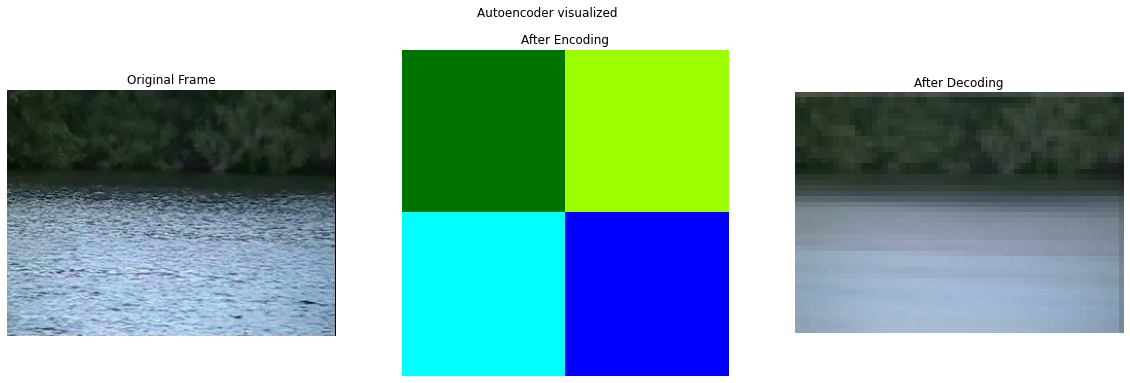

In [ ]:
# Look at a frame that pass through autoendoer
frame = X[800]

encoded = np.array(model.encode(frame.reshape((1, -1))))
decoded = np.array(model.call(frame.reshape((1, -1))))

fig, axs = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Autoencoder visualized')

axs[0].imshow(mpimg.imread(folder_path+ '/frame0800.jpg'))          # Load image directly
axs[0].set_title('Original Frame')
axs[0].axis('off')

axs[1].imshow(encoded.reshape((2, 2, 3)))
axs[1].set_title('After Encoding')
axs[1].axis('off')

axs[2].imshow(decoded.reshape((44, 60, 3)))
axs[2].set_title('After Decoding')
axs[2].axis('off')

# Part 3. Measure the reconstruction loss

In [ ]:
all_loss = []
for i in range(X.shape[0]):
    frame = X[i].reshape((1, -1))
    loss = model.evaluate(frame, frame, verbose=0)
    all_loss.append(loss)

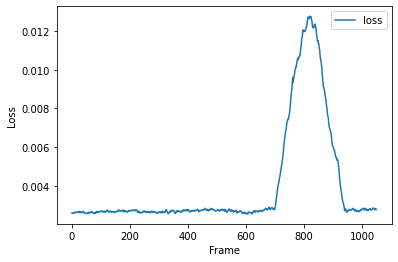

In [ ]:
plt.figure("Loss per Frame")
plt.plot(all_loss)
plt.xlabel('Frame')
plt.ylabel('Loss')
plt.legend(['loss'])
plt.show()

# Part 4. Set a threshold for anomaly

In [ ]:
# Returns frame numbers that passes the threshold
def get_anomaly_frames(loss_list, threshold):
    i = 0
    anomaly_list = []
    while i < len(loss_list):
        if loss_list[i] > threshold:
            anomaly_list.append(i)
        i += 1
    return anomaly_list

In [ ]:
# Check if the list contains only consecutive numbers
def check_consecutive(l):
    return sorted(l) == list(range(min(l), max(l)+1))

In [ ]:
# Using the two helper functions above, we can find a proper threshold, which only returns a consecutive list of anomaly frames
# This code is specific for this video, because we know there is only one occurrence of anomaly (a canoe passing by)
n = 1
threshold = np.median(all_loss) * n                                 # Initialize threshold to be median of all the loss
anomaly_frame_list = get_anomaly_frames(all_loss, threshold)        # Initialize the list of anomaly frames

while check_consecutive(anomaly_frame_list) is False:               # While the anomaly_frame_list is not consecutive
    n += 0.005                                                      # Increase n
    threshold = np.median(all_loss) * n                             # Calculate new threshold
    anomaly_frame_list = get_anomaly_frames(all_loss, threshold)    # Get new anomaly_frame_list

print(threshold)

0.0029142967367079067


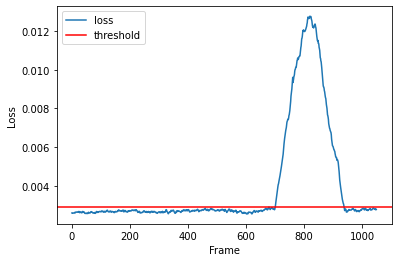

In [ ]:
plt.figure("Loss per Frame, with Threshold")
plt.plot(all_loss)
plt.xlabel('Frame')
plt.ylabel('Loss')
plt.axhline(y=threshold, color='r', linestyle='-')      # Show threshold
plt.legend(['loss', 'threshold'])
plt.show()

# Part 5. Predict new frames

In [ ]:
def predict_frame(model, frame, threshold):
    frame = frame.reshape((1, -1))
    loss = model.evaluate(frame, frame, verbose=0)
    if loss > threshold:
        return True
    else:
        return False

(-0.5, 319.5, 239.5, -0.5)

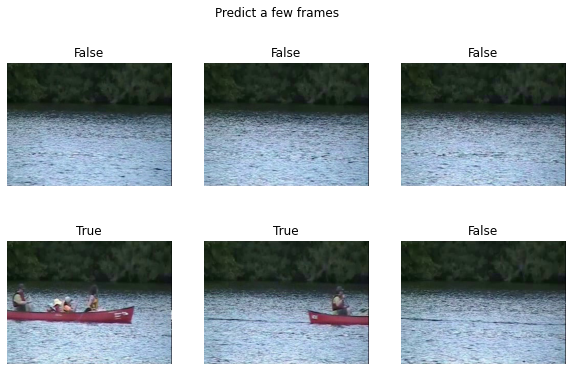

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(10, 6))
fig.suptitle('Predict a few frames')

axs[0, 0].imshow(mpimg.imread(folder_path+ '/frame0100.jpg'))
axs[0, 0].set_title(predict_frame(model, X[100], threshold))
axs[0, 0].axis('off')

axs[0, 1].imshow(mpimg.imread(folder_path+ '/frame0300.jpg'))
axs[0, 1].set_title(predict_frame(model, X[300], threshold))
axs[0, 1].axis('off')

axs[0, 2].imshow(mpimg.imread(folder_path+ '/frame0500.jpg'))
axs[0, 2].set_title(predict_frame(model, X[500], threshold))
axs[0, 2].axis('off')

axs[1, 0].imshow(mpimg.imread(folder_path+ '/frame0800.jpg'))
axs[1, 0].set_title(predict_frame(model, X[800], threshold))
axs[1, 0].axis('off')

axs[1, 1].imshow(mpimg.imread(folder_path+ '/frame0900.jpg'))
axs[1, 1].set_title(predict_frame(model, X[900], threshold))
axs[1, 1].axis('off')

axs[1, 2].imshow(mpimg.imread(folder_path+ '/frame1000.jpg'))
axs[1, 2].set_title(predict_frame(model, X[1000], threshold))
axs[1, 2].axis('off')

Anomaly: True


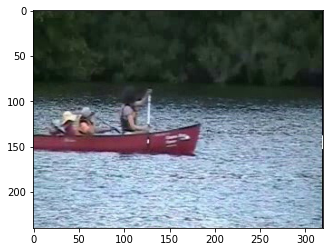

In [ ]:
# Predict a frame of your choice

# Set file name
im_fname = '/content/drive/MyDrive/Data Science/MMAI 5500/A2 Autoencoder/img/frame0775.jpg'

# Open this image, convert it to array and normalize between 0-1
im = Image.open(im_fname)
im_array = np.array(im.resize((60, 44)))
im_array = im_array.astype(np.float32) / 255.
im.close()

plt.imshow(mpimg.imread(im_fname))

# Make prediction
print('Anomaly:', predict_frame(model, im_array, threshold))

# Part 6. Identify anomaly object

Reference:

https://www.tutorialspoint.com/keras/keras_real_time_prediction_using_resnet_model.htm

In [ ]:
from tensorflow.keras.applications import resnet50
from keras.applications.imagenet_utils import decode_predictions

820
/content/drive/MyDrive/Data Science/MMAI 5500/A2 Autoencoder/img/frame0820.jpg


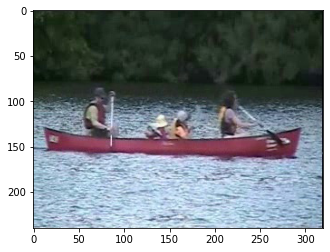

In [ ]:
# Look at the frame with highest loss (should be where the anomaly object is at center of frame)
index_max = np.argmax(all_loss)
print(index_max)

im_fname = f"{folder_path+'/'}frame{index_max:0>4}.jpg"
print(im_fname)

anomaly = mpimg.imread(im_fname)
plt.imshow(anomaly)

In [ ]:
# Convert the image into format accepted by ResNet (bath of array)
im = Image.open(im_fname)
im_array = np.array(im.resize((224, 224)))          # ResNet by default uses image size 224 x 224
im.close()

im_batch = np.expand_dims(im_array, axis = 0)
processed_image = resnet50.preprocess_input(im_batch.copy())

In [ ]:
# Load the pretrained ResNet model
resnet_model = resnet50.ResNet50(weights = 'imagenet')

102981632/102967424 [==============================] - 1s 0us/step


In [ ]:
# Make prediction and show result
predictions = resnet_model.predict(processed_image)
label = decode_predictions(predictions)

print(label)

49152/35363 [=========================================] - 0s 0us/step
[[('n02951358', 'canoe', 0.98778206), ('n03873416', 'paddle', 0.0066374126), ('n04273569', 'speedboat', 0.0013660092), ('n04612504', 'yawl', 0.0011762839), ('n03447447', 'gondola', 0.0008351721)]]


ResNet thinks this is a **canoe** (98.8%), which is the correct result

# Part 7. Try this on a new video

The same procedure is tested on other videos with minimal code changes. This proves the code has generic usage.

I took a segment from Toronto Zoo's Twitch channel. It shows a tiger passing by a grass field.

Video Source: https://www.twitch.tv/videos/1502044939

In [ ]:
# Load data
folder_path = '/content/drive/MyDrive/Data Science/MMAI 5500/A2 Autoencoder/img2'
video_path = '/content/drive/MyDrive/Data Science/MMAI 5500/A2 Autoencoder/zoo_video.mp4'

# convert_video_to_images(folder_path, video_path)

print('Frame Size:', mpimg.imread(folder_path+ '/frame0000.jpg').shape)

# Convert images to array
X, images = load_images(folder_path, im_width=85, im_height=48)         # width and height need to be adjusted based on video
print('X shape:', X.shape)
print('Length of images:', len(images))

Frame Size: (480, 852, 3)
X shape: (2154, 12240)
Length of images: 2154


In [ ]:
# Configurations of model
model = AutoEncoder(input_size=X.shape[1], compress_size=12)
model.compile(loss='mse', optimizer='adam')

model.fit(x=X, 
          y=X,                  # Since it's unsupervised, we just compare X with itself to check for loss
          epochs=10,
          batch_size=50)

Epoch 1/10
44/44 [==============================] - 1s 11ms/step - loss: 0.0042
Epoch 2/10
44/44 [==============================] - 0s 10ms/step - loss: 4.8335e-04
Epoch 3/10
44/44 [==============================] - 0s 10ms/step - loss: 5.0359e-04
Epoch 4/10
44/44 [==============================] - 0s 10ms/step - loss: 4.7010e-04
Epoch 5/10
44/44 [==============================] - 0s 10ms/step - loss: 3.5978e-04
Epoch 6/10
44/44 [==============================] - 0s 10ms/step - loss: 3.1999e-04
Epoch 7/10
44/44 [==============================] - 0s 10ms/step - loss: 3.2430e-04
Epoch 8/10
44/44 [==============================] - 0s 10ms/step - loss: 2.9552e-04
Epoch 9/10
44/44 [==============================] - 0s 10ms/step - loss: 2.5867e-04
Epoch 10/10
44/44 [==============================] - 0s 10ms/step - loss: 2.4481e-04


0.00019444878940703232


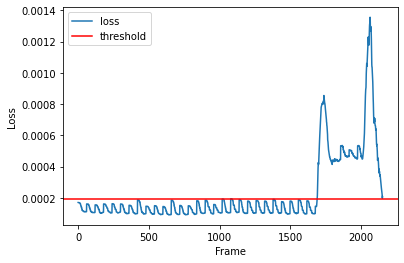

In [ ]:
# Calculate Loss
all_loss = []
for i in range(X.shape[0]):
    frame = X[i].reshape((1, -1))
    loss = model.evaluate(frame, frame, verbose=0)
    all_loss.append(loss)

# Find threshold
n = 1
threshold = np.median(all_loss) * n                                 # Initialize threshold to be median of all the loss
anomaly_frame_list = get_anomaly_frames(all_loss, threshold)        # Initialize the list of anomaly frames

while check_consecutive(anomaly_frame_list) is False:               # While the anomaly_frame_list is not consecutive
    n += 0.005                                                      # Increase n
    threshold = np.median(all_loss) * n                             # Calculate new threshold
    anomaly_frame_list = get_anomaly_frames(all_loss, threshold)    # Get new anomaly_frame_list

print(threshold)

# Plot loss and threshold
plt.figure("Loss per Frame, with Threshold")
plt.plot(all_loss)
plt.xlabel('Frame')
plt.ylabel('Loss')
plt.axhline(y=threshold, color='r', linestyle='-')      # Show threshold
plt.legend(['loss', 'threshold'])
plt.show()

(-0.5, 851.5, 479.5, -0.5)

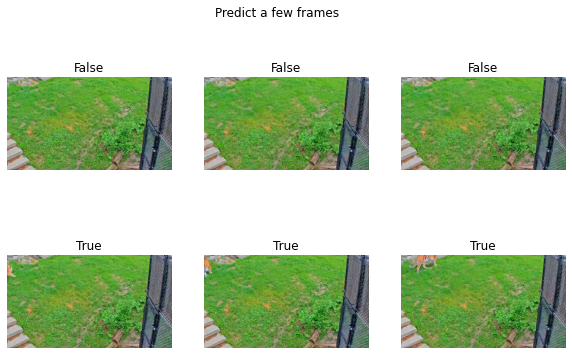

In [ ]:
# Show a few frames
fig, axs = plt.subplots(2, 3, figsize=(10, 6))
fig.suptitle('Predict a few frames')

axs[0, 0].imshow(mpimg.imread(folder_path+ '/frame0100.jpg'))
axs[0, 0].set_title(predict_frame(model, X[100], threshold))
axs[0, 0].axis('off')

axs[0, 1].imshow(mpimg.imread(folder_path+ '/frame0300.jpg'))
axs[0, 1].set_title(predict_frame(model, X[300], threshold))
axs[0, 1].axis('off')

axs[0, 2].imshow(mpimg.imread(folder_path+ '/frame0500.jpg'))
axs[0, 2].set_title(predict_frame(model, X[500], threshold))
axs[0, 2].axis('off')

axs[1, 0].imshow(mpimg.imread(folder_path+ '/frame1700.jpg'))
axs[1, 0].set_title(predict_frame(model, X[1700], threshold))
axs[1, 0].axis('off')

axs[1, 1].imshow(mpimg.imread(folder_path+ '/frame1900.jpg'))
axs[1, 1].set_title(predict_frame(model, X[1900], threshold))
axs[1, 1].axis('off')

axs[1, 2].imshow(mpimg.imread(folder_path+ '/frame2100.jpg'))
axs[1, 2].set_title(predict_frame(model, X[2100], threshold))
axs[1, 2].axis('off')

2065
/content/drive/MyDrive/Data Science/MMAI 5500/A2 Autoencoder/img2/frame2065.jpg


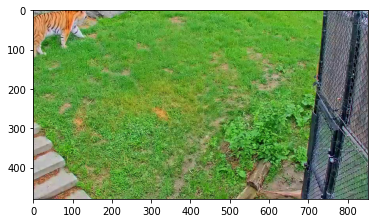

In [ ]:
# Look at the frame with highest loss (should be where the anomaly object is most obvious)
index_max = np.argmax(all_loss)
print(index_max)

im_fname = f"{folder_path+'/'}frame{index_max:0>4}.jpg"
print(im_fname)

anomaly = mpimg.imread(im_fname)
plt.imshow(anomaly)

In [ ]:
# Make prediction
im = Image.open(im_fname)
im_array = np.array(im.resize((224, 224)))          # ResNet by default uses image size 224 x 224
im.close()

im_batch = np.expand_dims(im_array, axis = 0)
processed_image = resnet50.preprocess_input(im_batch.copy())

predictions = resnet_model.predict(processed_image)
label = decode_predictions(predictions)

print(label)

[[('n02129604', 'tiger', 0.4304861), ('n02123159', 'tiger_cat', 0.16904831), ('n04604644', 'worm_fence', 0.050622005), ('n02391049', 'zebra', 0.033619367), ('n02437616', 'llama', 0.03355053)]]
